In [1]:
# first step: Connect your Google Drive into this notebook
# tip: use the file explorer on the left, and click the Google Drive-icon to connect
data_file_path = "/content/drive/MyDrive/Advancing Machine Learning/exercise_2/data/news_category_clean.csv"

In [2]:
# load the data to test if it works at all
import pandas as pd
df = pd.read_csv(data_file_path)

In [3]:
# quick check, does the data load?
df.head(3)

,category,authors,date,clean_headline,clean_description,year,month,headline_char_count,headline_word_count,avg_word_length
0,U.S. NEWS,"Carla K. Johnson, AP",2022-09-23,over million americans roll up sleeves for omi...,health experts said it is too early to predict...,2022,9,73,10,7.300000
1,U.S. NEWS,Mary Papenfuss,2022-09-23,american airlines flyer charged banned for lif...,he was subdued by passengers and crew when he ...,2022,9,88,13,6.769231
2,COMEDY,Elyse Wanshel,2022-09-23,of the funniest tweets about cats and dogs thi...,until you have a dog you dont understand what ...,2022,9,57,11,5.181818


## Step 1.5 - Do the same preprocessing as in the Naive-Bayes -example

In [4]:
# combine headline with short_description (to have a bit more data)
df['headline'] = df['clean_headline'] + " - " + df['clean_description']

In [5]:
# select only "category" and "headline" columns
# category is going to be the target
df = df[['category', 'headline']]

In [6]:
# DOUBLE-CHECK THE ORDER AFTER TARGET VARIABLE HAS BEEN ENCODED TO INTEGERS
TEXT_LABELS = ['HEALTHY LIVING', 'COMEDY', 'FOOD & DRINK', 'BUSINESS']

In [7]:
# List of categories to filter
categories_to_filter = TEXT_LABELS

# Filter rows where category is in the list
df = df[df['category'].isin(categories_to_filter)]

In [8]:
# final check, is the data otherwise good to go?
df.head()

,category,headline
2,COMEDY,of the funniest tweets about cats and dogs thi...
162,BUSINESS,rei workers at berkeley store vote to unionize...
280,FOOD & DRINK,cafeteria workers do a lot more than people re...
294,FOOD & DRINK,i cooked for the worlds but i traded it to mak...
344,COMEDY,of the funniest tweets about cats and dogs thi...


In [9]:
df['category'].value_counts()

,count
category,
HEALTHY LIVING,6642
FOOD & DRINK,6299
BUSINESS,5956
COMEDY,5278


In [10]:
df.isnull().sum() # cheking null value

,0
category,0
headline,3000


In [11]:
df = df.dropna()  # removing null values

In [12]:
df['category'].value_counts()

,count
category,
FOOD & DRINK,6290
HEALTHY LIVING,5228
BUSINESS,5101
COMEDY,4556


In [13]:
num_samples_to_select = 5250

if len(df) > num_samples_to_select:
    df = df.sample(n=num_samples_to_select, random_state=42).reset_index(drop=True)
    print(f"Dataset reduced to {num_samples_to_select} samples.")
else:
    print(f"Dataset has {len(df)} samples, which is less than or equal to the requested {num_samples_to_select}. Using all available samples.")

df.tail()

Dataset reduced to 5250 samples.


,category,headline
5245,BUSINESS,why levis is giving away its trade secrets - t...
5246,FOOD & DRINK,food jargon words you absolutely need to know ...
5247,FOOD & DRINK,chocolate idiot cake is the easiest recipe you...
5248,COMEDY,hes back jon stewart returns with a message fo...
5249,HEALTHY LIVING,how to mend a broken heart - the need to mend ...


In [14]:
df

,category,headline
0,HEALTHY LIVING,is living forever going to suck - we might be ...
1,FOOD & DRINK,the spring vegetables were so excited for - br...
2,BUSINESS,perhaps we need corporate loyalty oaths - we h...
3,BUSINESS,unequal realities inside the jobs report - tod...
4,HEALTHY LIVING,big tobacco is still in the business of deceiv...
...,...,...
5245,BUSINESS,why levis is giving away its trade secrets - t...
5246,FOOD & DRINK,food jargon words you absolutely need to know ...
5247,FOOD & DRINK,chocolate idiot cake is the easiest recipe you...
5248,COMEDY,hes back jon stewart returns with a message fo...


In [15]:
!pip install nltk
!pip install stopwords

In [16]:
# this phase usually takes time, since its made by CPU
# might be a better idea to save the processed version to another csv-file
# import nltk for stopword removal
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import multiprocessing as mp

# remove stopwords
nltk.download('stopwords')

# define a function which we can apply to our data
# => remove English stopwords (filler words)
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stopwords.words('english')]
    return ' '.join(words)

# apply the function to the 'headline' column
df['headline'] = df['headline'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
# import Torch + neural network features
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# import HuggingFace transformers, BERT imports
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoModel, AutoModelForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput

# rest of the needed imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# import matplotlib for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# enable Torch to use GPU if its available, default back to CPU if not available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check which device is used
print(f"Using device: {device}")

# Remember: you want to use cuda (GPU) for this
# if you run out of free GPU credits, you can try CPU but with a very small dataset
# = less than 2000 rows TOTAL for training

Using device: cuda


## Step 3: Define the dataset wrapper + training -function for Torch

In [18]:
# Dataset class for text data, to be used by Torch training code
# we need this data wrapper in order to finetune the BERT Model
class TextDataset(Dataset):
    # initialize the dataset: texts = training data, labels = target values
    # which tokenizer to use for this data and what is the maximum length of a single
    # piece of data (512)
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [19]:
# model training function for Torch
def train_model(model, train_dataloader, val_dataloader, epochs=3, lr=2e-5):
    # make this model use the current device (GPU or CPU)
    model.to(device)

    # as per common with NLP tasks => optimizer is AdamW
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # our loss function is Cross Entropy
    loss_fn = nn.CrossEntropyLoss()

    # Training progress trackers for training metrics later!
    # note: this is built-in in Keras, but not in Torch and TensorFlow Core
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # traing for as many epochs as defined
    for epoch in range(epochs):
        # initialize variables for this epoch
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        # EPOCH TRAINING - PHASE 1: train the model
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        # keep track of current accuracy and loss for TRAINING DATA
        history['train_acc'].append(correct / total)
        history['train_loss'].append(total_loss / len(train_dataloader))
        print(f"Epoch {epoch+1}: Train Loss = {total_loss / len(train_dataloader)}, Train Accuracy = {correct / total}")

        # EPOCH VALIDATION - PHASE 2: validate this epoch
        model.eval()
        correct, total, total_val_loss = 0, 0, 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                total_val_loss += loss.item()
                correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)

        # keep track of current accuracy and loss for VALIDATION DATA
        history['val_acc'].append(correct / total)
        history['val_loss'].append(total_val_loss / len(val_dataloader))

        # this epoch's done, print the the current progress into notebook
        print(f"Validation Loss = {total_val_loss / len(val_dataloader)}, Validation Accuracy = {correct / total}")
        print("------------------------------------------")

    return history

In [20]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df['category_encoded'] = label_encoder.fit_transform(df['category'])

In [21]:
df.head()

,category,headline,category_encoded
0,HEALTHY LIVING,living forever going suck - might sick enjoy e...,3
1,FOOD & DRINK,spring vegetables excited - bring spring,2
2,BUSINESS,perhaps need corporate loyalty oaths - drifted...,0
3,BUSINESS,unequal realities inside jobs report - todays ...,0
4,HEALTHY LIVING,big tobacco still business deceiving americans...,3


In [22]:
# Asked from AI, prompt: show all possible combinations of category and category_encoded in df
for category, encoded in zip(df['category'].unique(), df['category_encoded'].unique()):
  print(f"Category: {category}, Encoded: {encoded}")


Category: HEALTHY LIVING, Encoded: 3
Category: FOOD & DRINK, Encoded: 2
Category: BUSINESS, Encoded: 0
Category: COMEDY, Encoded: 1


In [23]:
# based on the result above, this is the order of labels
# correct the labels here if needed
TEXT_LABELS = ['HEALTHY LIVING', 'COMEDY', 'FOOD & DRINK', 'BUSINESS']

In [24]:
# X/y split!
X = df['headline']
y = df['category_encoded']

In [25]:
# next step, download the BERT model and the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('google/bert_uncased_L-2_H-128_A-2', num_labels=len(TEXT_LABELS))

# model.classifier = nn.Sequential(
#     nn.Dropout(0.3),
#     nn.Linear(model.config.hidden_size, 64),
#     nn.ReLU(),
#     nn.Linear(64, len(TEXT_LABELS))
# )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/39 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: google/bert_uncased_L-2_H-128_A-2
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [26]:
# because of Torch datasets, the train/test -split is slightly different
train_texts, val_texts, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# convert series to lists
train_texts = train_texts.tolist()
val_texts = val_texts.tolist()
train_labels = train_labels.tolist()
val_labels = val_labels.tolist()

# Create datasets and dataloaders
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# as in Image AIs => shuffle the training data, but don't shuffle the validation data
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [27]:
# train the model
history = train_model(model, train_dataloader, val_dataloader, epochs=10)

Epoch 1: Train Loss = 1.1765448854083107, Train Accuracy = 0.5916666666666667
Validation Loss = 0.9070129543542862, Validation Accuracy = 0.7676190476190476
------------------------------------------
Epoch 2: Train Loss = 0.7812980290253957, Train Accuracy = 0.8085714285714286
Validation Loss = 0.6370580063173266, Validation Accuracy = 0.8314285714285714
------------------------------------------
Epoch 3: Train Loss = 0.5569299534105119, Train Accuracy = 0.8464285714285714
Validation Loss = 0.5133475542745807, Validation Accuracy = 0.8438095238095238
------------------------------------------
Epoch 4: Train Loss = 0.44341245239689236, Train Accuracy = 0.871904761904762
Validation Loss = 0.4702597035828865, Validation Accuracy = 0.86
------------------------------------------
Epoch 5: Train Loss = 0.3690317380995978, Train Accuracy = 0.893095238095238
Validation Loss = 0.45553854277188127, Validation Accuracy = 0.8647619047619047
------------------------------------------
Epoch 6: Train

## Training and error metrics!

<Axes: >

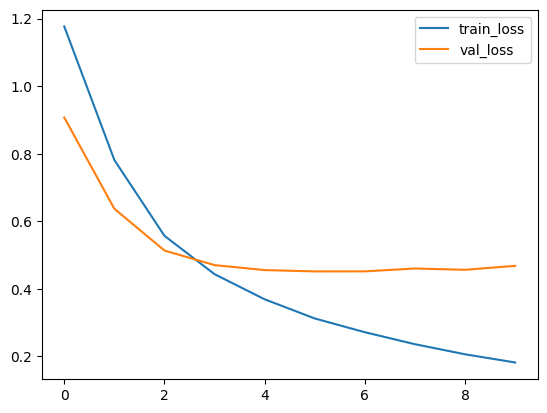

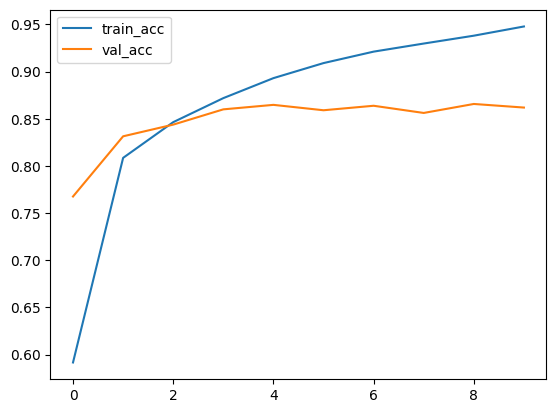

In [28]:
loss_df = pd.DataFrame(history)
loss_df[['train_loss', 'val_loss']].plot()
loss_df[['train_acc', 'val_acc']].plot()

In [29]:
# we need to process the data in batches in Torch in order to
# the true values and the matching predictions

model.eval()
y_true = []
y_pred = []

# process through testing dataset and collect true and prediction values for metrics
with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.logits.argmax(dim=1).cpu().numpy())

# classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       245
           1       0.83      0.87      0.85       223
           2       0.92      0.92      0.92       322
           3       0.85      0.84      0.84       260

    accuracy                           0.86      1050
   macro avg       0.86      0.86      0.86      1050
weighted avg       0.86      0.86      0.86      1050



<Axes: >

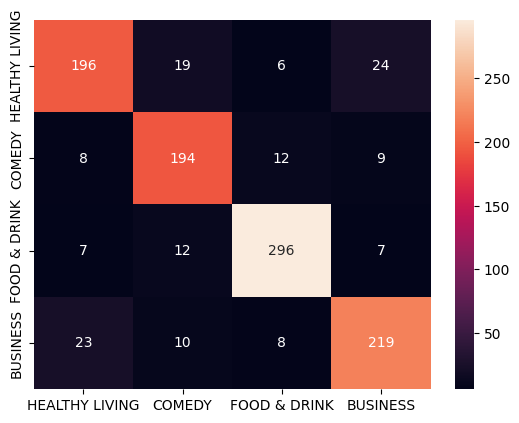

In [30]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g',
            xticklabels=TEXT_LABELS, yticklabels=TEXT_LABELS)

# interesting result, here we can see how SPORTS and ENTERTAINMENT are close to each other
# while in Naive-Bayes it was BUSINESS vs ENTERTAINMENT

# we can probably assume a little that WORD-WISE Business is close to Entertainment news '
# (because of similar word usage), but context/semantic -wise, Sports and Entertainment
# are close to each other (which is detected by BERT -> which is a transformer)

In [31]:
# get one-hot representation of y_true and y_pred
y_true_onehot = pd.get_dummies(y_true).values
y_pred_onehot = pd.get_dummies(y_pred).values

print(f"ROC AUC: {roc_auc_score(y_true_onehot, y_pred_onehot, multi_class='ovr')}")

ROC AUC: 0.9060485697547062


In [32]:
# test the model
model.eval()

# our example news headline
sample = "Comedian forgets his own punchline during live show and starts laughing uncontrollably, forcing the audience to finish the joke for him while security tries not to laugh on stage."

# process the text so it can be put through the model
encoding = tokenizer(sample, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
outputs = model(input_ids, attention_mask=attention_mask)
label = outputs.logits.argmax(dim=1).item()

# logits don't work similarly as probabilities (0-100%)
# it's more like => whatever is the biggest value => prediction
# similar values might imply problems though
# basically this is the format without softmax

print(f"Sample text: {sample}")
print(f"Predicted sentiment: {TEXT_LABELS[label]}")

# convert the raw logits into probabilities / softmax
probs = torch.nn.functional.softmax(outputs.logits, dim=1)

# convert the scientific format into decimal format
formatted_probs = [f"{p:.6f}" for p in probs.cpu().squeeze().tolist()]

# Print formatted probabilities
print()
print("Predictions for each label:\n")
print(TEXT_LABELS)
print(formatted_probs)

Sample text: GM and Stellantis just laid off more than 2,000 additional workers because of the UAW’s strike - GM said it idled an assembly plant in Kansas because of a shortage of parts due to the strike. About 2,000 of its workers were laid off Wednesday.
Predicted sentiment: HEALTHY LIVING

Predictions for each label:

['HEALTHY LIVING', 'COMEDY', 'FOOD & DRINK', 'BUSINESS']
['0.957480', '0.013729', '0.003109', '0.025682']
